In [1]:
import warnings
warnings.filterwarnings("ignore")
import cv2
import numpy as np
import skimage.io
import os
import sys
import matplotlib.pyplot as plt
import math
from scipy import ndimage
import pandas as pd
import seaborn as sns
from random import randint, uniform
from tqdm import tqdm
from collections import Counter
from itertools import permutations, product
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split

import xgboost as xgb
from tensorflow.keras.datasets import mnist

sys.path.append('../src/inference')
from utils import *

test_data = '../data/test/img'

# MNIST dataset

In [2]:
(X_train_mnist, y_train_mnist), (X_test_mnist, y_test_mnist) = mnist.load_data()

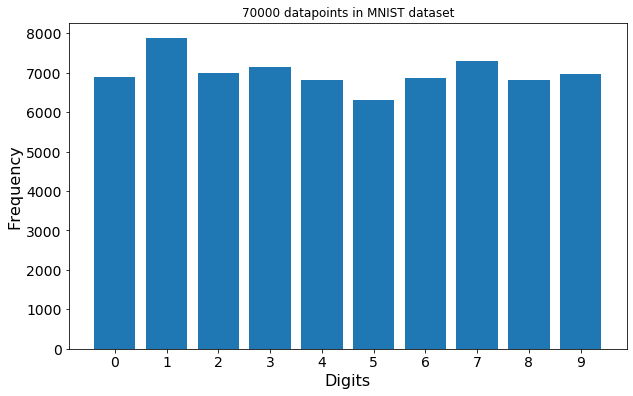

In [3]:
data_mnist = np.concatenate((X_train_mnist, X_test_mnist), axis=0).reshape(-1,28,28,1)
target_mnist = np.concatenate((y_train_mnist, y_test_mnist), axis=0)

col = np.unique(target_mnist)
digits_no = num_classes = len(col)
counts_mnist = Counter(target_mnist)

plt.figure(figsize=(10,6))
plt.bar(counts_mnist.keys(), counts_mnist.values(), width = 0.8)
plt.tick_params(labelsize = 14)
plt.xticks(list(counts_mnist.keys()))
plt.xlabel("Digits",fontsize=16)
plt.ylabel("Frequency",fontsize=16)
plt.title('%s datapoints in MNIST dataset'%(target_mnist.shape[0]))

plt.show()

# Resampling of MNIST dataset to train/val/test format

In [4]:
X_train, X, y_train, y = train_test_split(data_mnist, target_mnist, test_size = 0.2, stratify=target_mnist)
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size = 0.5, stratify = y)

y_train = to_categorical(np.expand_dims(y_train, axis=1))
y_val = to_categorical(np.expand_dims(y_val, axis=1))
y_test = to_categorical(np.expand_dims(y_test, axis=1))

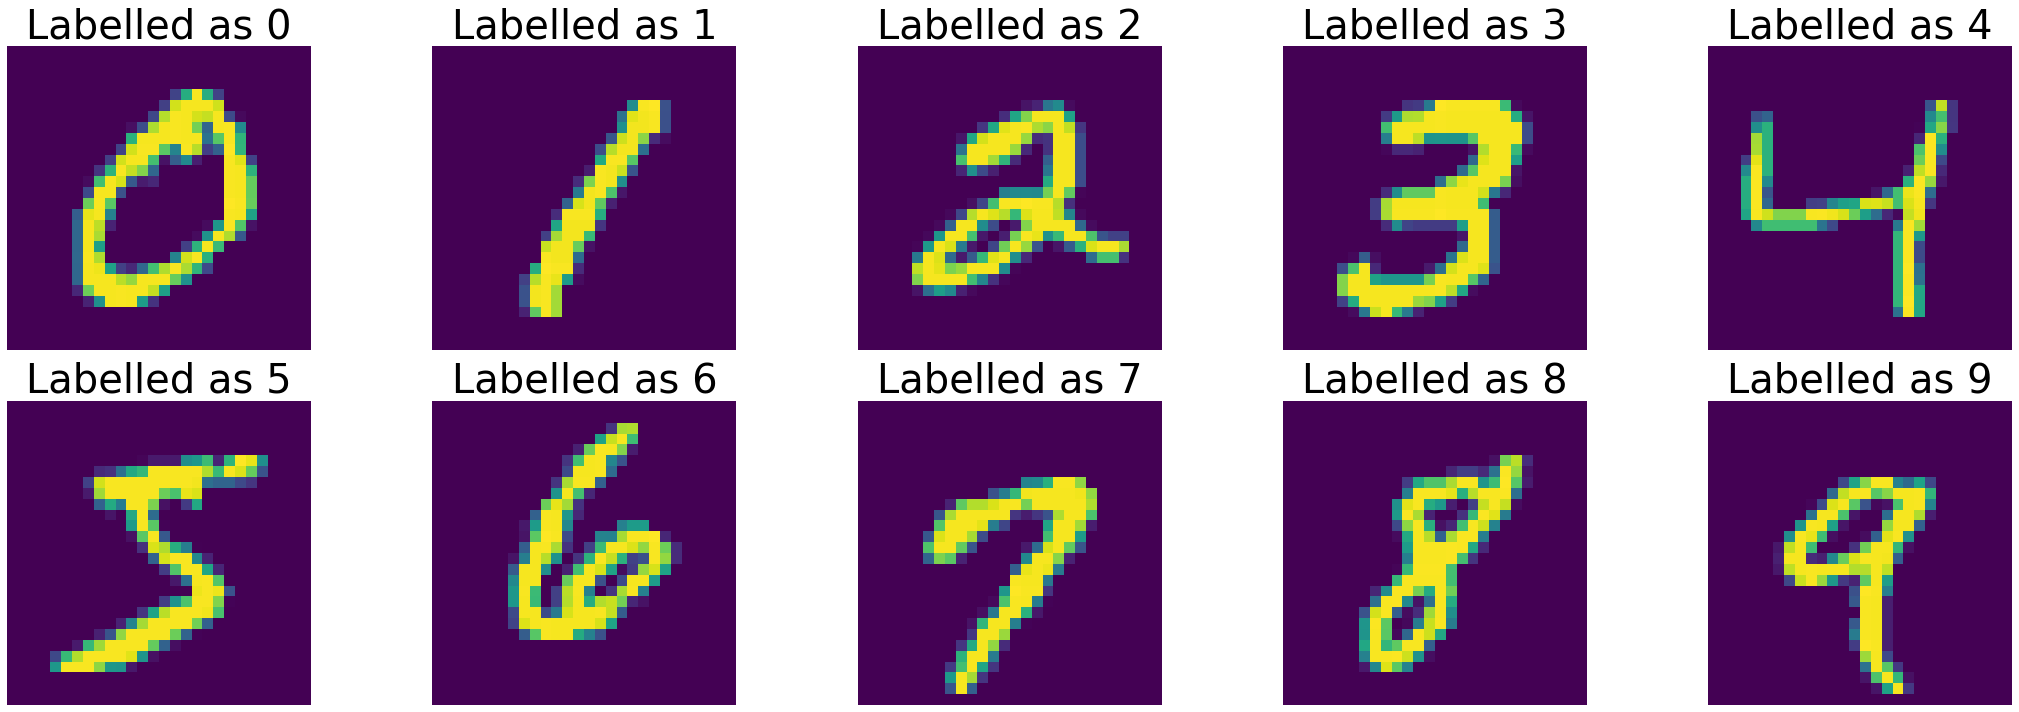

In [5]:
plt.figure(figsize=(30,10))

for idx in range(digits_no):
    index = np.where(target_mnist==idx)[0][0]
    img = data_mnist[index]
    
    plt.subplot(2,5,idx+1)
    plt.title('Labelled as %s'%(idx), fontsize=40)
    plt.imshow(img.reshape(28,28))
    plt.axis('off')

plt.tight_layout()

# Digit classification using neural network

In [ ]:
model = Sequential()

model.add(Conv2D(32, (5, 5), input_shape=(28,28,1), activation='relu'))
model.add(MaxPooling2D())
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=1, validation_data=(X_val, y_val))

# Training metrics

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(20, 7))
plt.subplot(1,2,1)
train_loss_plot, = plt.plot(range(1, len(loss)+1), loss, label='Train Loss')
val_loss_plot, = plt.plot(range(1, len(val_loss)+1), val_loss, label='Validation Loss')
_ = plt.legend(handles=[train_loss_plot, val_loss_plot])

plt.subplot(1,2,2)
train_acc_plot, = plt.plot(range(1, len(acc)+1), acc, label='Training accuracy')
val_acc_plot, = plt.plot(range(1, len(val_acc)+1), val_acc, label='Validation accuracy')
_ = plt.legend(handles=[train_acc_plot, val_acc_plot])

# Evaluation

In [ ]:
preds = model.predict(X_test)

print("Precision = {:.4f}".format(precision_score(np.squeeze(y_test), preds, average='macro')))
print("Recall = {:.4f}".format(recall_score(np.squeeze(y_test), preds, average='macro')))
print("F1-score = {:.4f}".format(f1_score(np.squeeze(y_test), preds)))
print("Accuracy = {:.4f}".format(accuracy_score(np.squeeze(y_test), preds)))

In [ ]:
res = confusion_matrix(y_test, preds)
confusion = pd.DataFrame(res, columns=col, index = col)
confusion.index.name, confusion.columns.name = 'Actual', 'Predicted'

plt.figure(figsize = (10,8))
sns.heatmap(confusion, annot=True, cmap='Blues')
plt.title('Test accuracy: %.4f' % (accuracy_score(np.squeeze(y_test), preds)))

# Test over sudoku tile data

In [ ]:
img_sudoku = cv2.imread(os.path.join(test_data,'clear.jpg'))[:, :, [2, 1, 0]]
gray_sudoku = cv2.cvtColor(img_sudoku, cv2.COLOR_RGB2GRAY)

centroid, (grid, vis), bbox = get_res(img_sudoku)

fig = plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(img_sudoku)
plt.title('Input image')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(grid)
plt.title('Grid retrieval')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(vis)
plt.title('Centroid retrieval')
plt.axis('off')
plt.tight_layout()

plt.show()

In [ ]:
plt.figure(figsize=(20,20))
for idx, bb in enumerate(bbox):
    x0, x1, y0, y1 = bb
    inv = np.uint8(np.invert(gray_sudoku[y0:y1,x0:x1]))
    img_resize = cv2.resize(inv, (28,28), interpolation=cv2.INTER_LINEAR).reshape(1,-1)
    l = None if np.max(inv) > 150 else np.argmax(model.predict(img_resize))
    
    plt.subplot(9,9,idx+1)
    plt.imshow(inv)
    plt.axis('off')
    plt.title('%s'%(l),fontsize=20)

plt.tight_layout()

It appears that training on MNIST dataset does not generalize well over computer created digits.

## Data creation

In [ ]:
def text_on_img(text, size=3, center=False):
    font = ['DejaVu Sans','Arial','sans-serif', 'fantasy', 'monospace', 'sans', 'sans serif', 'serif']
    
    fig, ax = plt.subplots()
    ax.text(0+uniform(0.0, 0.6 if not center else 0.25),
            0+uniform(0.0, 0.6 if not center else 0.25),
            '%s'%(text), 
            fontsize=250+randint(0,50),
            fontweight=100+randint(-50,50),
            fontname=font[randint(0,len(font)-1)])
    plt.axis('off')
    fig.canvas.draw()
    data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
    w, h = fig.canvas.get_width_height()
    plt.close(fig)
    
    vis = np.invert(data.reshape((int(h), int(w), -1))[:, :, [2, 1, 0]])
    vis = cv2.cvtColor(vis,cv2.COLOR_RGB2GRAY)
    vis = cv2.blur(vis,(9,9))
    vis = cv2.resize(vis,(28,28))
    
    return vis.reshape(-1,784)

In [ ]:
s = 6000 # Number of datapoint to be created per digit
balance = [(idx,s) for idx in range(digits_no)] # Digits-volume dictionnary
data_editor = np.zeros((digits_no*s,784)) # Flatten image 28x28 pixels
target_editor = np.zeros((digits_no*s,1)) # Label data

k=0
for (key, val) in balance:
    print('Creating training data for digit %s'%(key))
    for j in tqdm(range(val), position = 0):
        data_editor[k,:] = text_on_img(str(key))
        target_editor[k,:] = np.array(key)
        k+=1
target_editor = np.squeeze(target_editor)

# Data preparation & visualization

As creating twice the amount of data for being able to recognize both handritten and editor created digits, I decided to reduce the number of data taken from MNIST as high accuracy can be expected with fewer number of datapoints.
In order to make my dataset totally balanced, I downsampled each class of MNIST dataset to 4.000 datapoints with their corresponding image and combine it with artificailly created images.

In [ ]:
undersample = RandomUnderSampler({i:s for i in list(range(digits_no))}, random_state=0)
data_mnist, target_mnist = undersample.fit_resample(data_mnist, target_mnist)

data = np.concatenate((data_editor, data_mnist), axis=0)
target = np.concatenate((target_editor, target_mnist + 10), axis=0)

X_train, X, y_train, y = train_test_split(data, target, test_size=0.2, random_state=0, stratify=target)
X_val, X_test, y_val, y_test = train_test_split(X, y, test_size=0.5, random_state=0, stratify=y)

# Stratification from both handwritten and editor based should be fixed
y_train[np.where(y_train > 9)] -= 10
y_val[np.where(y_val > 9)] -= 10
y_test[np.where(y_test > 9)] -= 10

In [ ]:
editor = list(Counter(target_editor).values())
mnist = list(Counter(target_mnist).values())

plt.figure(figsize=(10,6))
mnist_plot = plt.bar(np.arange(digits_no), mnist, 0.35)
editor_plot = plt.bar(np.arange(digits_no), editor, 0.35, bottom=mnist)

plt.tick_params(labelsize = 14)
plt.xticks(list(range(digits_no)))
plt.xlabel("Digits", fontsize=16)
plt.ylabel('Occurence', fontsize=16)
plt.legend((mnist_plot[0], editor_plot[0]), ('MNIST', 'Editor'))
plt.title('%s datapoints'%(target.shape[0]))

plt.show()

# Train

In [ ]:
# # XGBoost setting and training
# cls_all = xgb.XGBClassifier(**params_xgb).fit(X_train,
#                                               y_train,
#                                               early_stopping_rounds = 5,
#                                               eval_metric = ['merror','mlogloss'],
#                                               eval_set = [(X_train, y_train), (X_val, y_val)],
#                                               verbose = False)

# Training metrics

In [ ]:
# # Training metrics
# results = cls_all.evals_result()
# epochs = len(results['validation_0']['mlogloss'])
# x_axis = range(0, epochs)

# # Plot log loss
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
# ax1.plot(x_axis, results['validation_0']['mlogloss'], label='Train')
# ax1.plot(x_axis, results['validation_1']['mlogloss'], label='Val')
# ax1.legend(fontsize=15)
# ax1.set_xlabel('epoch', fontsize=15)
# ax1.set_ylabel('Log Loss', fontsize=15)

# # Plot classification error
# ax2.plot(x_axis, [1-x for x in results['validation_0']['merror']], label='Train')
# ax2.plot(x_axis, [1-x for x in results['validation_1']['merror']], label='Val')
# ax2.legend(fontsize=15)
# ax2.set_xlabel('epoch', fontsize=15)
# ax2.set_ylabel('Accuracy', fontsize=15)

# plt.tight_layout()

## Evaluation

In [ ]:
# preds = cls_all.predict(X_test)

In [ ]:
# print("Precision = {:.4f}".format(precision_score(np.squeeze(y_test), preds, average='macro')))
# print("Recall = {:.4f}".format(recall_score(np.squeeze(y_test), preds, average='macro')))
# print("F1-score = {:.4f}".format(f1_score(np.squeeze(y_test), preds)))
# print("Accuracy = {:.4f}".format(accuracy_score(np.squeeze(y_test), preds)))

In [ ]:
# res = confusion_matrix(y_test, preds)
# confusion = pd.DataFrame(res, columns=col, index = col)
# confusion.index.name, confusion.columns.name = 'Actual', 'Predicted'

# plt.figure(figsize = (10,8))
# sns.heatmap(confusion, annot=True, cmap='Blues')
# plt.title('Test accuracy: %.4f' % (accuracy_score(np.squeeze(y_test), preds)))

# Test batch data

In [ ]:
display_col = 5

plt.figure(figsize=(30,30))
for digit, idx in itertools.product(range(digits_no), range(display_col)):
    img = X_test[np.where(y_test==digit)[0][idx]]
    pred = cls_all.predict(img)
    
    plt.subplot(digits_no + 1, display_col, digit + idx + 1)
    plt.title('Labelled as %s'%(pred), fontsize=40)
    plt.imshow(img.reshape(28,28))
    plt.axis('off')

plt.tight_layout()

# Visualization over sudoku data

In [ ]:
plt.figure(figsize=(20,20))
for idx, bb in enumerate(bbox):
    x0, x1, y0, y1 = bb
    inv = np.uint8(np.invert(gray_sudoku[y0:y1,x0:x1]))
    img_resize = cv2.resize(inv, (28,28), interpolation=cv2.INTER_LINEAR).reshape(1,-1)
#     l = None if np.max(inv) > 150 else cls_all.predict(img_resize)
    
    plt.subplot(9,9,idx+1)
    plt.imshow(inv)
    plt.axis('off')
#     plt.title('%s'%(l),fontsize=20)

plt.tight_layout()